In [1]:
# Import des packages utiles au projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn import preprocessing as pp
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from graphviz import Source
from itertools import cycle
import seaborn as sns



In [2]:
#Fichiers à importer, à scorer et définition du répertoire pour la sauvegarde des résultats

URL_ADULT ='/Users/teriitehau/Desktop/2020-2021/Méthode_de_scoring/fraude_mobile_phone_ech/fraude_mobile_phone_ech_train.csv'
URL_ADULT_test ='/Users/teriitehau/Desktop/2020-2021/Méthode_de_scoring/fraude_mobile_phone_ech/fraude_mobile_phone_ech_test.csv'


dir_res = r'C:\Tanguy\Enseignement\IAE Nantes Master EKAP\Cours Fraude Python\results'


# Import du fichier adult.csv
df_train = pd.read_csv(URL_ADULT, skipinitialspace=True)
df_test = pd.read_csv(URL_ADULT_test, skipinitialspace=True)
stats_desc_dftrain = df_train.describe() #Description des variables quanti
stats_desc_dftest = df_test.describe() #Description des variables quanti


In [3]:
#vue nature des variables
print(df_train.info(), "\n")
print(df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB
None 

(500000, 11)


In [4]:
#dimension des bases 
print(df_train.shape,
df_test.shape )


# Calcul du nombre de données manquantes par variable
nb_null_by_vartrain = np.sum(pd.isnull(df_train))
print(nb_null_by_vartrain)
nb_null_by_var_test = np.sum(pd.isnull(df_test))
print(nb_null_by_var_test)

#aucune valeur manquante 


(500000, 11) (250000, 11)
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
df_train.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:

df_train["echantillon"] = "train"
df_test["echantillon"] = "test"

frames= [df_train,df_test]
nrw_df = pd.concat(frames,axis=0)# 0 permet d'empiler par ligne

#régénerer index 
nrw_df = nrw_df.reset_index(drop=True)
 

#creation train et test_index (recup index des individus)
train_index = list(nrw_df[(nrw_df.echantillon=='train')].index)
train_index[:100]
test_index = list(nrw_df[(nrw_df.echantillon=='test')].index)
total = len(df_train)
total_amt = df_train.groupby(['isFraud'])['amount'].sum().sum()

In [7]:
#creation d'une variable
df_train['dest']=0
df_test['dest']= 0

df_train['dest']= df_train['nameDest'].str.split('(\d.+)', n = 0, expand = True)
df_test['dest']= df_test['nameDest'].str.split('(\d.+)', n = 0, expand = True)

In [8]:
df_train['dest'].value_counts()

C    335968
M    164032
Name: dest, dtype: int64

In [9]:
df_test['dest'].value_counts()

C    164805
M     85195
Name: dest, dtype: int64

In [10]:
pd.crosstab(df_train['dest'], df_train['isFraud'])
#pas de fraude chez les commerce (pour destinaire)

isFraud,0,1
dest,,
C,335735,233
M,164032,0


In [11]:
pd.crosstab(df_test['dest'], df_test['isFraud'])
#pas de fraude chez les commerce (pour destinaire)

isFraud,0,1
dest,,
C,164584,221
M,85195,0


In [12]:
#creation d'une variable 
df_train['old_compte_zero_dest'] = 0
df_train.loc[(df_train['oldbalanceDest']==0.0),'old_compte_zero_dest']=1


df_test['old_compte_zero_dest'] = 0
df_test.loc[(df_test['oldbalanceDest']==0.0),'old_compte_zero_dest']=1


#vu le pdf pour 'newbalanceDest' la transaction 
# n'est pas mis a zero. 
df_train['new_compte_zero_dest'] = 0
df_train.loc[(df_train['newbalanceDest']==0),'new_compte_zero_dest']=1

df_test['new_compte_zero_dest'] = 0
df_test.loc[(df_test['newbalanceDest']==0),'new_compte_zero_dest']=1

In [13]:
df_train['old_compte_zero_dest'].value_counts()

0    297237
1    202763
Name: old_compte_zero_dest, dtype: int64

In [14]:
df_train['new_compte_zero_dest'].value_counts()

0    306747
1    193253
Name: new_compte_zero_dest, dtype: int64

In [15]:
pd.crosstab(df_train['old_compte_zero_dest'], df_train['isFraud'])

isFraud,0,1
old_compte_zero_dest,,
0,297148,89
1,202619,144


In [16]:
pd.crosstab(df_train['new_compte_zero_dest'], df_train['isFraud'])

isFraud,0,1
new_compte_zero_dest,,
0,306618,129
1,193149,104


In [17]:
#Les ind qui ont un oldbalancedest et newbalancedest à 0 et dest C 
df_train['OrigC_zero_dest'] = 0
df_train.loc[(df_train['oldbalanceDest']==0) & 
            (df_train['dest']=='C')&
            (df_train['newbalanceDest']==0), 'OrigC_zero_dest']=1


df_test['OrigC_zero_dest'] = 0
df_test.loc[(df_test['oldbalanceDest']==0) & 
            (df_test['dest']=='C')&
            (df_test['newbalanceDest']==0), 'OrigC_zero_dest']=1

In [18]:
pd.crosstab(df_train['OrigC_zero_dest'], df_train['isFraud'])

isFraud,0,1
OrigC_zero_dest,,
0,489338,139
1,10429,94


In [19]:
pd.crosstab(df_test['OrigC_zero_dest'], df_test['isFraud'])

isFraud,0,1
OrigC_zero_dest,,
0,243780,115
1,5999,106


In [20]:
df_train.loc[(df_train['newbalanceOrig']==0) &
            (df_train['dest']=='C')&
            (df_train['isFraud']==1)]
# il y a 229 observation pour les transaction avec newbalanceorig à 0 et fraude 
# représentant un majorité des transaction de fraude

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,echantillon,dest,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,train,C,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,train,C,0,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0,train,C,1,1,1
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0,train,C,0,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0,train,C,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481251,19,CASH_OUT,10000000.00,C2050703310,10000000.00,0.0,C1622860679,504326.62,10342417.90,1,0,train,C,0,0,0
481252,19,TRANSFER,1861008.32,C1990303942,1861008.32,0.0,C1308678191,0.00,0.00,1,0,train,C,1,1,1
481253,19,CASH_OUT,1861008.32,C1718961034,1861008.32,0.0,C714051433,0.00,1789942.62,1,0,train,C,1,0,0
499609,20,TRANSFER,16614.82,C2080146129,16614.82,0.0,C748889213,0.00,0.00,1,0,train,C,1,1,1


In [21]:
#Les ind qui ont newbalanceOrig zero car la majorité de la fraude provient d'eux
#quand le destinaire est un C
df_train['Orig_newbal_zero_destC'] = 0
df_train.loc[(df_train['newbalanceOrig']==0) &
            (df_train['dest']=='C'),'Orig_newbal_zero_destC']=1

df_test['Orig_newbal_zero_destC'] = 0
df_test.loc[(df_test['newbalanceOrig']==0) &
            (df_test['dest']=='C'),'Orig_newbal_zero_destC']=1

In [22]:
pd.crosstab(df_train['Orig_newbal_zero_destC'], df_train['isFraud'])

isFraud,0,1
Orig_newbal_zero_destC,,
0,301619,4
1,198148,229


In [23]:
df_train['Erreur_orig']= df_train['newbalanceOrig']+df_train['amount']-df_train['oldbalanceOrg']
df_test['Erreur_orig']= df_test['newbalanceOrig']+df_test['amount']-df_test['oldbalanceOrg']


df_train['Erreur_dest']= df_train['oldbalanceDest']+df_train['amount']-df_train['newbalanceDest']
df_test['Erreur_dest']= df_test['oldbalanceDest']+df_test['amount']-df_test['newbalanceDest']

In [24]:
df_train.loc[
            (df_train['Erreur_dest']>0)& 
            (df_train['isFraud']==1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,echantillon,dest,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest,Orig_newbal_zero_destC,Erreur_orig,Erreur_dest
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,train,C,1,1,1,1,0.0,181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,train,C,0,1,0,1,0.0,21363.00
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0,train,C,1,1,1,1,0.0,2806.00
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0,train,C,0,1,0,1,0.0,29008.00
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0,train,C,1,1,1,1,0.0,20128.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481250,19,TRANSFER,10000000.00,C416779475,11861008.32,1861008.32,C380259496,0.00,0.00,1,0,train,C,1,1,1,0,0.0,10000000.00
481251,19,CASH_OUT,10000000.00,C2050703310,10000000.00,0.00,C1622860679,504326.62,10342417.90,1,0,train,C,0,0,0,1,0.0,161908.72
481252,19,TRANSFER,1861008.32,C1990303942,1861008.32,0.00,C1308678191,0.00,0.00,1,0,train,C,1,1,1,1,0.0,1861008.32
481253,19,CASH_OUT,1861008.32,C1718961034,1861008.32,0.00,C714051433,0.00,1789942.62,1,0,train,C,1,0,0,1,0.0,71065.70


In [25]:
df_train.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest,Orig_newbal_zero_destC,Erreur_orig,Erreur_dest
count,500000.000000,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,500000.000000,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,5.000000e+05,5.000000e+05
mean,13.906728,1.663937e+05,9.116928e+05,9.314261e+05,9.827739e+05,1.162668e+06,0.000466,0.0,0.405526,0.386506,0.021046,0.396754,1.861270e+05,-1.350061e+04
std,3.731891,2.725841e+05,3.016901e+06,3.054015e+06,2.336426e+06,2.510610e+06,0.021582,0.0,0.490994,0.486949,0.143538,0.489225,2.947810e+05,5.636258e+05
min,1.000000,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-1.000000e-02,-3.514216e+07
25%,11.000000,1.335032e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.532537e+03,0.000000e+00
50%,14.000000,8.137560e+04,1.856900e+04,0.000000e+00,1.192711e+05,2.221441e+05,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.212002e+04,5.280300e+03
75%,17.000000,2.226441e+05,1.702941e+05,2.101716e+05,8.962267e+05,1.201403e+06,0.000000,0.0,1.000000,1.000000,0.000000,1.000000,2.610834e+05,4.318177e+04
max,20.000000,1.000000e+07,3.893942e+07,3.894623e+07,4.148270e+07,4.148270e+07,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,6.388051e+06,1.319123e+07


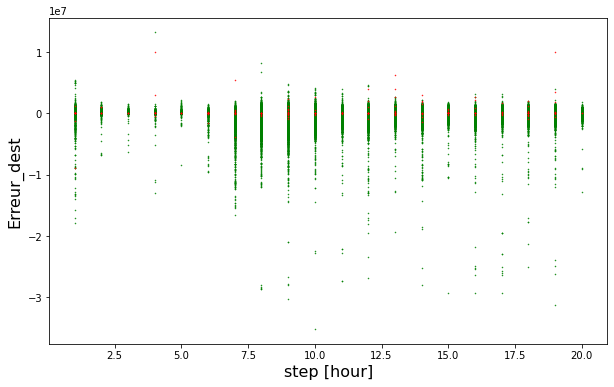

In [26]:
x = 'Erreur_dest'
y = 'step'
Y = df_train['isFraud']
X = df_train
plt.figure(figsize = (10,6))
ax = plt.scatter(X.loc[Y==0, y], X.loc[Y==0, x], c = 'g', marker = '.', s = 1, label = 'genuine')
ax = plt.scatter(X.loc[Y==1, y], X.loc[Y==1, x], c = 'r', marker = '.', s = 1, label = 'fraudulent')
plt.ylabel(x, size=16);
plt.xlabel(y +' [hour]', size=16 )
plt.show()

In [27]:
print(229/(233))

0.9828326180257511


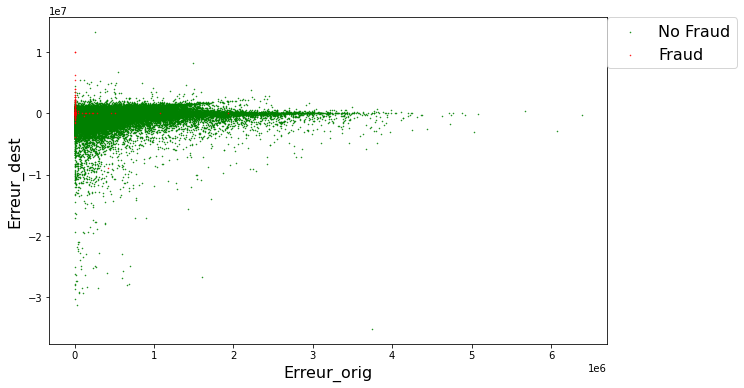

In [52]:
x = 'Erreur_dest'
y = 'Erreur_orig'
Y = df_train['isFraud']
X = df_train
plt.figure(figsize = (10,6))
ax = plt.scatter(X.loc[Y==0, y], X.loc[Y==0, x], c = 'g', marker = '.', s = 1, label = 'genuine')
ax = plt.scatter(X.loc[Y==1, y], X.loc[Y==1, x], c = 'r', marker = '.', s = 1, label = 'fraudulent')
plt.ylabel(x, size=16);
plt.xlabel(y , size=16 )
plt.legend(['No Fraud','Fraud'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.show()

In [57]:
df_train.loc[
            (df_train['Orig_newbal_zero_destC']==1)& 
            (df_train['isFraud']==1),['type','amount','oldbalanceOrg','newbalanceOrig',
                                     'oldbalanceDest','newbalanceDest','Erreur_orig','Erreur_dest']].head(20)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Erreur_orig,Erreur_dest
2,TRANSFER,181.00,181.00,0.0,0.00,0.00,0.00,181.00
3,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,0.00,21363.00
251,TRANSFER,2806.00,2806.00,0.0,0.00,0.00,0.00,2806.00
252,CASH_OUT,2806.00,2806.00,0.0,26202.00,0.00,0.00,29008.00
680,TRANSFER,20128.00,20128.00,0.0,0.00,0.00,0.00,20128.00
681,CASH_OUT,20128.00,20128.00,0.0,6268.00,12145.85,0.00,14250.15
724,CASH_OUT,416001.33,0.00,0.0,102.00,9291619.62,416001.33,-8875516.29
969,TRANSFER,1277212.77,1277212.77,0.0,0.00,0.00,0.00,1277212.77
970,CASH_OUT,1277212.77,1277212.77,0.0,0.00,2444985.19,0.00,-1167772.42
1115,TRANSFER,35063.63,35063.63,0.0,0.00,0.00,0.00,35063.63


In [54]:
df_train.head(4)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,echantillon,dest,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest,Orig_newbal_zero_destC,calcul_erreur_orig,calcul_erreur_dest,Erreur_orig,Erreur_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,train,M,1,1,0,0,0.0,9839.64,0.0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,train,M,1,1,0,0,0.0,1864.28,0.0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,train,C,1,1,1,1,0.0,181.00,0.0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,train,C,0,1,0,1,0.0,21363.00,0.0,21363.00


In [24]:
pd.crosstab(df_test['Orig_newbal_zero_destC'], df_test['isFraud'])

isFraud,0,1
Orig_newbal_zero_destC,,
0,150267,1
1,99512,220


In [25]:
pd.crosstab(df_train['type'], df_train['isFraud'])

isFraud,0,1
type,,
CASH_IN,109319,0
CASH_OUT,182195,121
DEBIT,3603,0
PAYMENT,164032,0
TRANSFER,40618,112


In [26]:
pd.crosstab(df_test['type'], df_test['isFraud'])

isFraud,0,1
type,,
CASH_IN,54360,0
CASH_OUT,87407,114
DEBIT,1468,0
PAYMENT,85195,0
TRANSFER,21349,107


In [27]:
stats = df_train[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
stats.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05
mean,1.663937e+05,9.116928e+05,9.314261e+05,9.827739e+05,1.162668e+06
std,2.725841e+05,3.016901e+06,3.054015e+06,2.336426e+06,2.510610e+06
min,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.335032e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.137560e+04,1.856900e+04,0.000000e+00,1.192711e+05,2.221441e+05
75%,2.226441e+05,1.702941e+05,2.101716e+05,8.962267e+05,1.201403e+06
max,1.000000e+07,3.893942e+07,3.894623e+07,4.148270e+07,4.148270e+07


In [28]:
stats = df_train.loc[(df_train['isFraud']==1),['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
stats.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,2.330000e+02,2.330000e+02,2.330000e+02,2.330000e+02,2.330000e+02
mean,8.329005e+05,8.313662e+05,2.374726e+04,4.087797e+05,9.456569e+05
std,1.668775e+06,1.797836e+06,2.293614e+05,1.554738e+06,2.189358e+06
min,1.190000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.012800e+04,1.370711e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.430320e+05,8.963124e+04,0.000000e+00,0.000000e+00,2.287700e+04
75%,9.944532e+05,9.635321e+05,0.000000e+00,4.417011e+04,6.784196e+05
max,1.000000e+07,1.293042e+07,2.930418e+06,1.301050e+07,1.307123e+07


In [29]:
stats = df_train.loc[(df_train['isFraud']==0),['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
stats.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,4.997670e+05,4.997670e+05,4.997670e+05,4.997670e+05,4.997670e+05
mean,1.660830e+05,9.117303e+05,9.318493e+05,9.830415e+05,1.162769e+06
std,2.698829e+05,3.017355e+06,3.054660e+06,2.336698e+06,2.510748e+06
min,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.334702e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.135710e+04,1.853500e+04,0.000000e+00,1.195091e+05,2.222303e+05
75%,2.225769e+05,1.701059e+05,2.103648e+05,8.967099e+05,1.201629e+06
max,6.419835e+06,3.893942e+07,3.894623e+07,4.148270e+07,4.148270e+07


AttributeError: module 'seaborn' has no attribute 'plt'

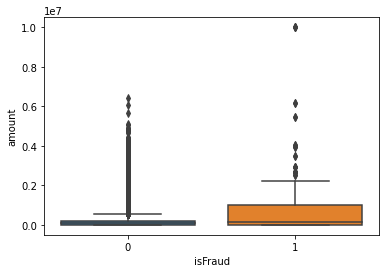

In [29]:
ax = sns.boxplot(x="isFraud", y="amount", 
                data=df_train)
sns.plt.title("isFraud by amount",fontsize=12);

In [29]:
df_train['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Same-signed fingerprints of genuine and fraudulent transactions over amount')

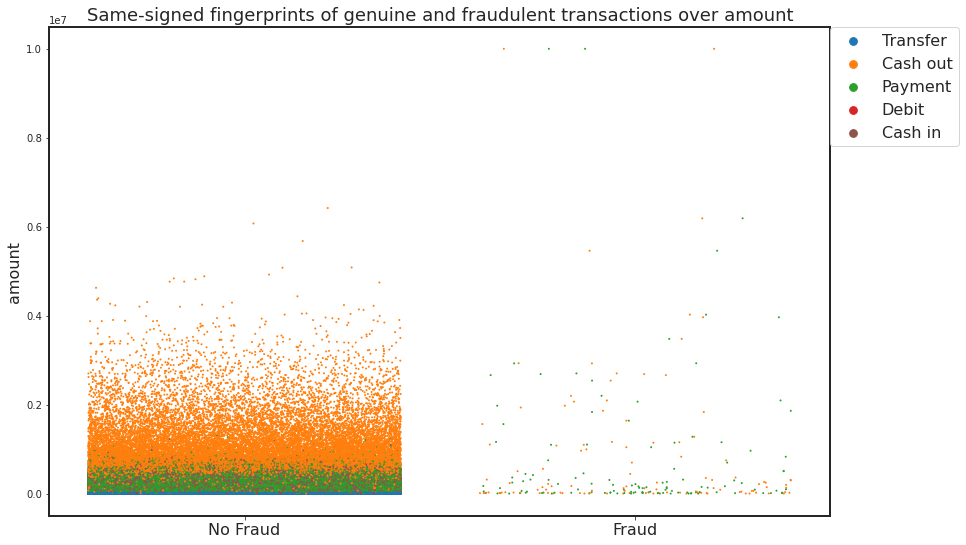

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['No Fraud', 'Fraud'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out', 'Payment', 'Debit','Cash in'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

limit = len(df_train)
Y = df_train['isFraud']
ax = plotStrip(Y[:limit], df_train.amount[:limit], df_train.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine and fraudulent transactions over amount', size = 18)

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Opposite polarity fingerprints over the error in destination account balances')

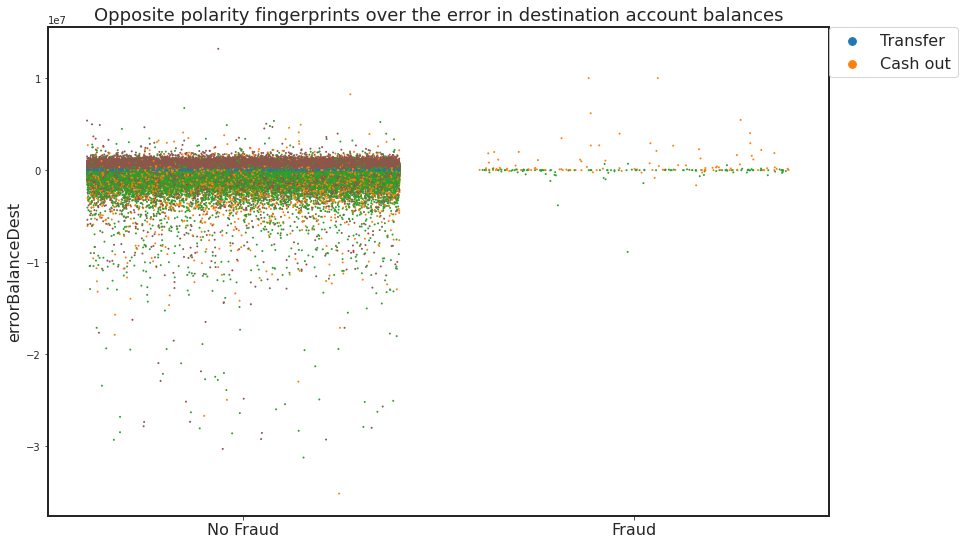

In [28]:
X=df_train
limit = len(X)
ax = plotStrip(Y[:limit], X.calcul_erreur_dest[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in destination account balances', size = 18)

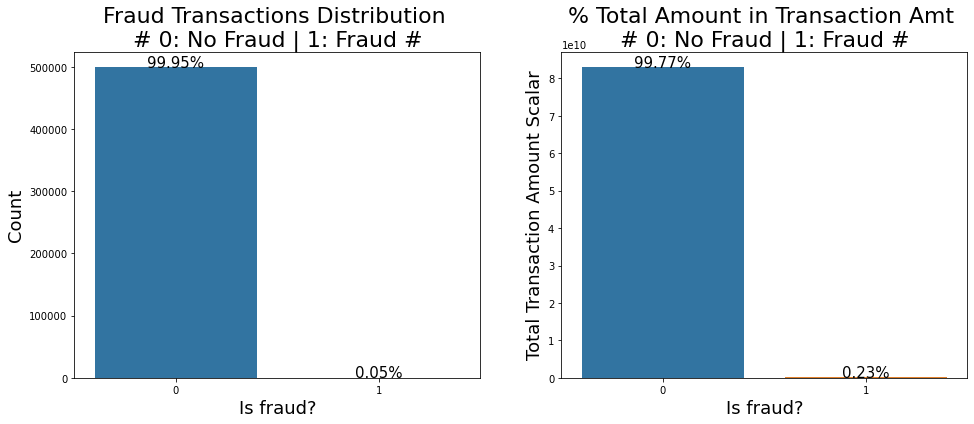

In [30]:
df_train['amount'] = df_train['amount'].astype(float)
total = len(df_train)
total_amt = df_train.groupby(['isFraud'])['amount'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_train.groupby(['isFraud'])['amount'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='amount',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

In [60]:
def graphique0(base,col): 
    df_trans = base
    df_trans['TransactionAmt']= df_trans[col]


    plt.figure(figsize=(16,12))
    plt.suptitle('Transaction Values Distribution', fontsize=22)
    plt.subplot(221)
    g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 2.226441e+05]['TransactionAmt'])
    g.set_title("Transaction Amount Distribuition <= 2.226441e+05", fontsize=18)
    g.set_xlabel("")
    g.set_ylabel("Probability", fontsize=15)

    plt.subplot(222)
    g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
    g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
    g1.set_xlabel("")
    g1.set_ylabel("Probability", fontsize=15)

    plt.figure(figsize=(16,12))


    plt.subplot(221)
    g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                     np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                     label='NoFraud', alpha=.2)
    g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                     np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                     label='Fraud', alpha=.2)
    g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
    g4 = plt.xlabel("Index")
    g4 = plt.ylabel("Amount Distribution", fontsize=15)
    g4 = plt.legend()

    plt.subplot(222)
    g = sns.distplot(np.log(df_trans[df_trans['isFraud'] == 0]['TransactionAmt']), label='NoFraud')
    g = sns.distplot(np.log(df_trans[df_trans['isFraud'] == 1]['TransactionAmt']), label='Fraud')
    g= plt.title("Transaction Amount (Log) Distribuition by Fraud", fontsize=18)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    plt.figure(figsize=(16,12))

    plt.subplot(321)
    g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]), 
                     np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                    label='isFraud', alpha=.4, color = 'orange')
    plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
    plt.xlabel("Index")
    plt.ylabel("Amount Distribution", fontsize=12)

    plt.subplot(322)
    g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                     np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                     label='NoFraud', alpha=.2)
    g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
    g1 = plt.xlabel("Index")
    g1 = plt.ylabel("Amount Distribution", fontsize=15)

    plt.suptitle('Individual ECDF Distribution', fontsize=22)

    plt.show()

In [61]:
df_train.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,echantillon,dest,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest,Orig_newbal_zero_destC,TransactionAmt
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,train,M,1,1,0,0,9839.64


/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

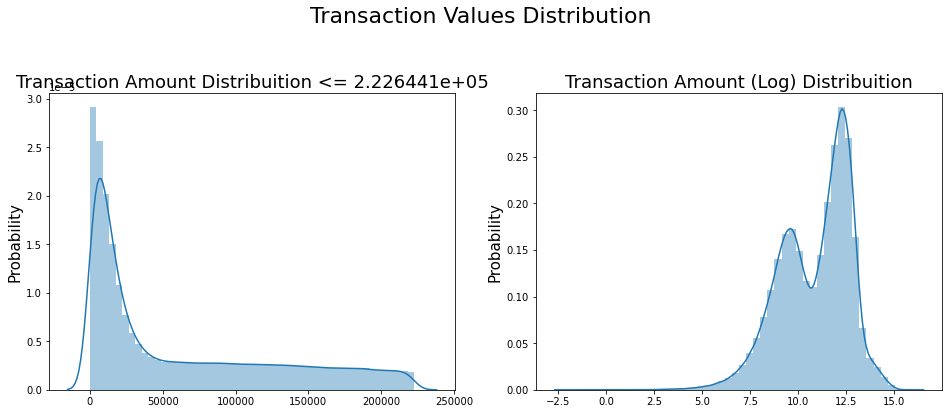

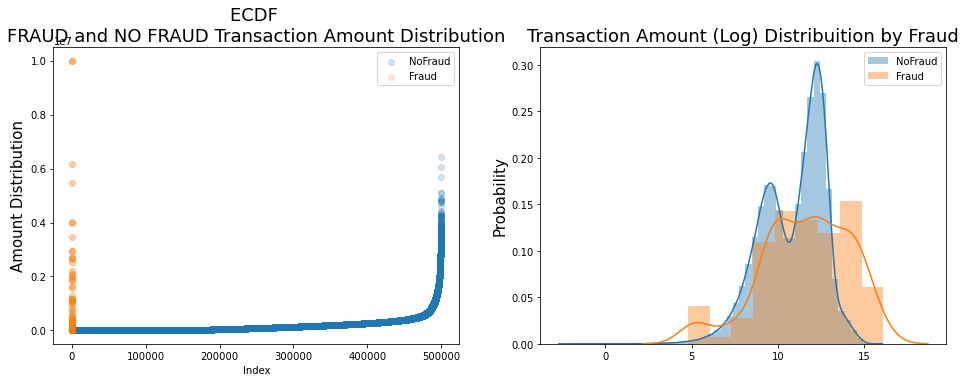

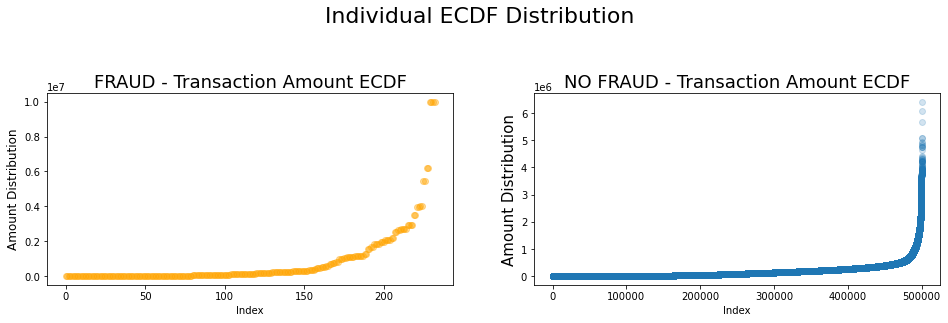

In [63]:
graphique0(df_train,'amount')

   isFraud  amount
0        0  499767
1        1     233


<AxesSubplot:>

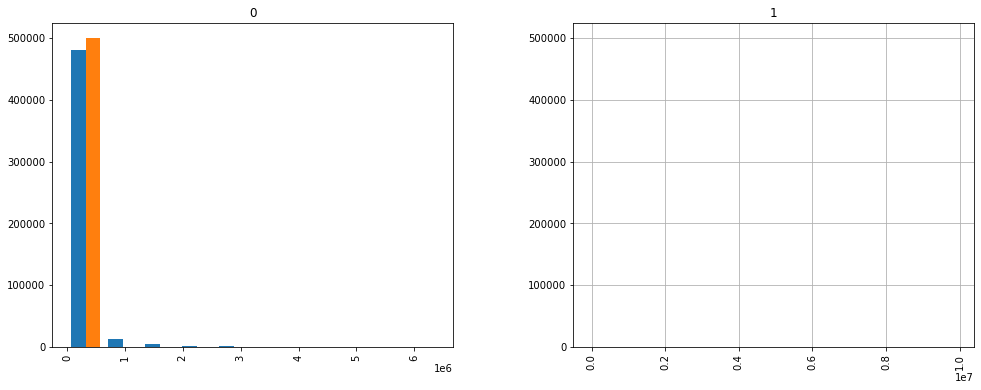

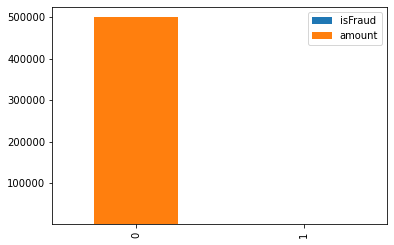

In [30]:

dist = df_train[["amount","isFraud"]].groupby("isFraud", as_index=False).count()
dist_graph = df_train[["amount","isFraud"]]
dist_graph.head
dist_graph.hist(by='isFraud',grid=False)

print(dist)
df_train["isFraud"].hist(figsize=(16,6), bins=50)
dist.plot.bar(stacked=True)



In [38]:
def graphique_1(base,titre) :#fonction graphique 
    titre = titre
    tmp = pd.crosstab(base['type'], base['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(titre, fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x='type', data=base)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title("Type ", fontsize=19)
    g.set_ylim(0,420000)
    g.set_xlabel("Type Category Names", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 


    plt.subplot(222)
    g1 = sns.countplot(x='type', hue='isFraud', data=base)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x='type', y='isFraud', data=base, 
                   color='black', legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g1.set_title("Type by Target(isFraud)", fontsize=19)
    g1.set_xlabel("Type Category Names", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x='type', y='amount', hue='isFraud', 
              data=base )
    g3.set_title("Type Distribuition by amount and Target", fontsize=20)
    g3.set_xlabel("Type Category Names", fontsize=17)
    g3.set_ylabel("Type Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.6, top = 0.85)

    plt.show()

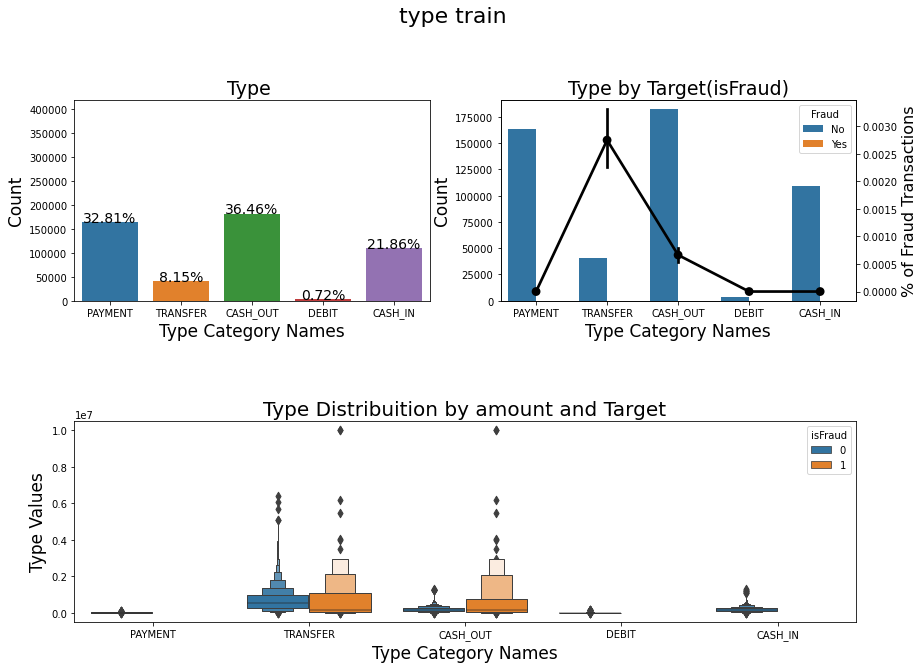

In [40]:
graphique_1(df_train, 'type train')

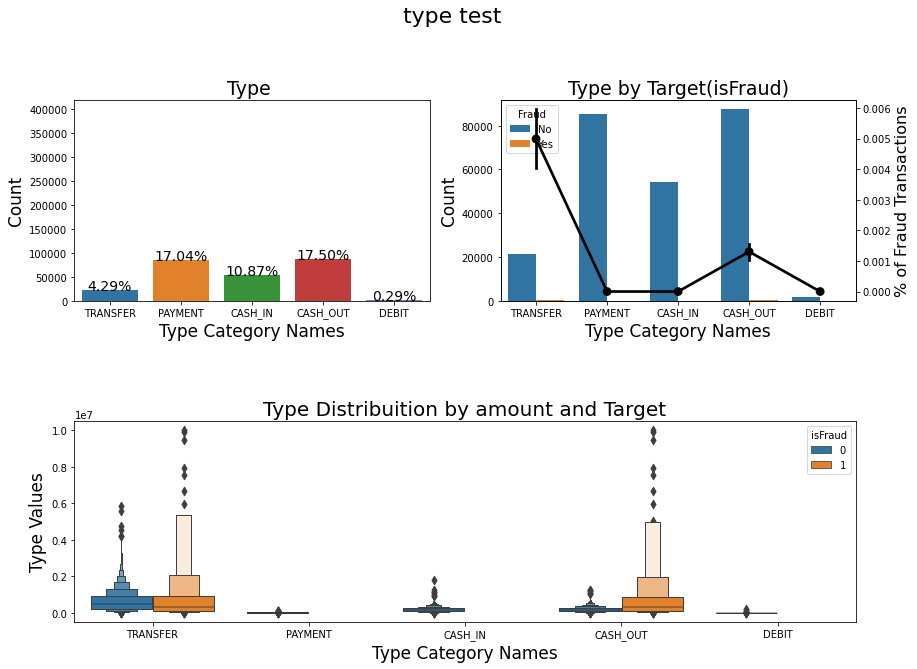

In [41]:
graphique_1(df_test, 'type test')

In [40]:
tmp = pd.crosstab(df_train['type'], df_train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
print(tmp)

isFraud      type          0         1
0        CASH_OUT  99.933632  0.066368
1        TRANSFER  99.725018  0.274982


In [42]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['amount'].sum() \
                / df.groupby([col])['amount'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['amount'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='amount', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by amount Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

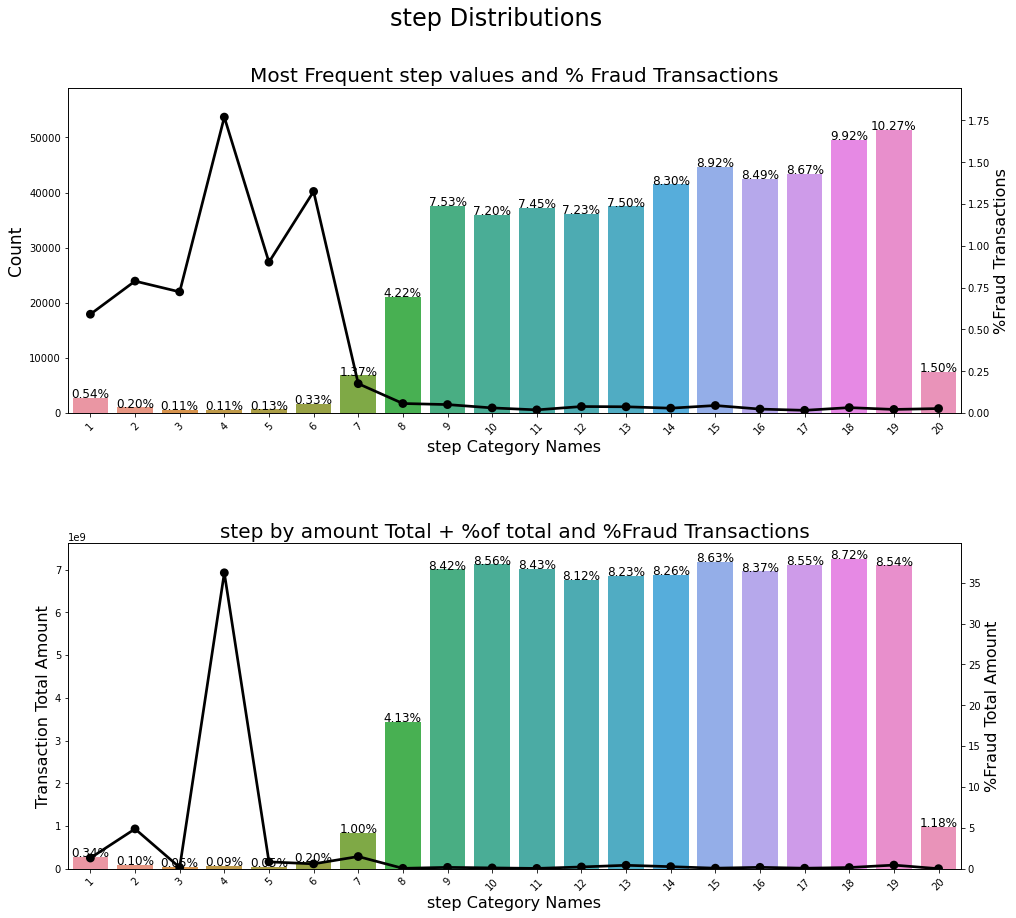

In [43]:
ploting_cnt_amt(df_train, 'step')

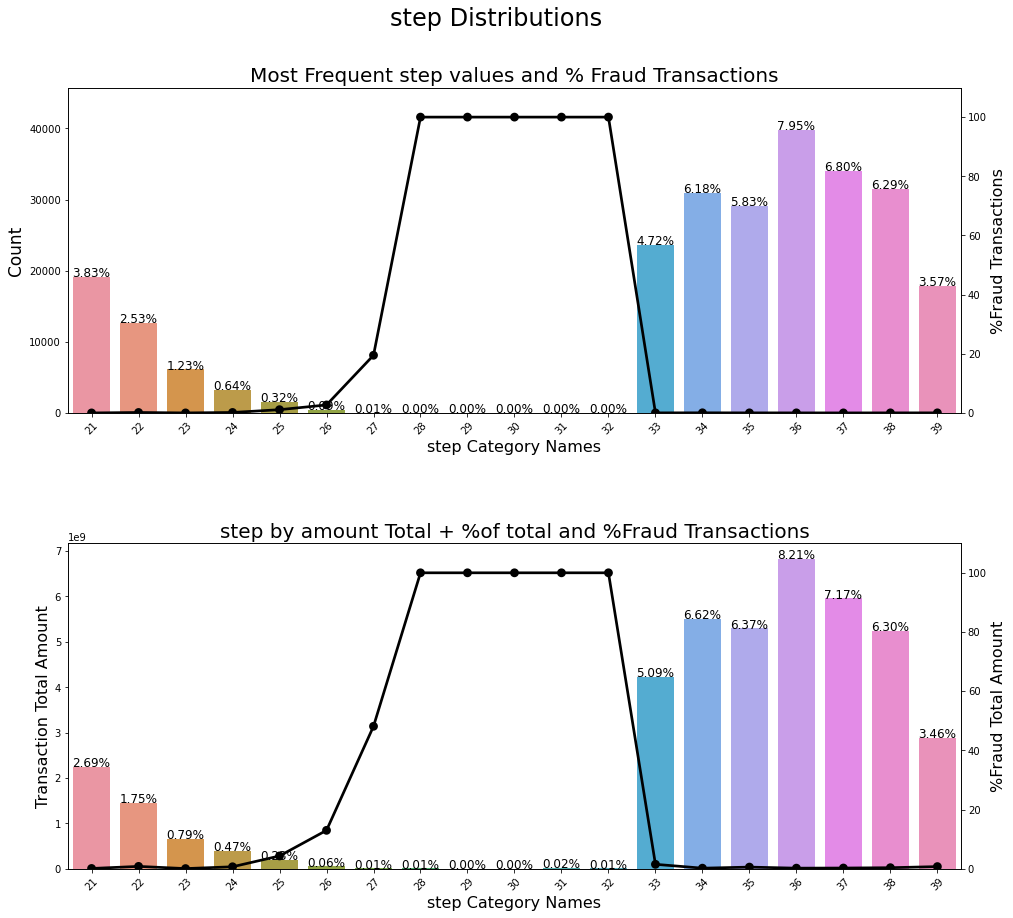

In [44]:
ploting_cnt_amt(df_test, 'step')

In [55]:
    tmp = pd.crosstab(df_train['step'], df_train['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    print(tmp)

isFraud  step          0         1
0           1  99.409158  0.590842
1           2  99.211045  0.788955
2           3  99.275362  0.724638
3           4  98.230088  1.769912
4           5  99.097744  0.902256
5           6  98.674699  1.325301
6           7  99.824484  0.175516
7           8  99.943120  0.056880
8           9  99.949506  0.050494
9          10  99.969437  0.030563
10         11  99.981204  0.018796
11         12  99.961276  0.038724
12         13  99.962682  0.037318
13         14  99.971074  0.028926
14         15  99.955166  0.044834
15         16  99.976455  0.023545
16         17  99.983856  0.016144
17         18  99.967728  0.032272
18         19  99.978579  0.021421
19         20  99.973394  0.026606


In [57]:
stats = df_train.loc[(df_train['isFraud']==1)&(df_train['step']==10),
                     ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
stats['amount'].describe()

count    1.100000e+01
mean     6.305434e+05
std      1.020584e+06
min      9.217190e+03
25%      5.983500e+04
50%      9.381076e+04
75%      5.034059e+05
max      2.662735e+06
Name: amount, dtype: float64

In [58]:
df_train.loc[(df_train['amount']==10000000)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,echantillon,dest,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest,Orig_newbal_zero_destC,TransactionAmt
4440,4,TRANSFER,10000000.0,C7162498,12930418.44,2930418.44,C945327594,0.00,0.00,1,0,train,C,1,1,1,0,10000000.0
4441,4,CASH_OUT,10000000.0,C351297720,10000000.00,0.00,C766681183,0.00,9941904.21,1,0,train,C,1,0,0,1,10000000.0
481250,19,TRANSFER,10000000.0,C416779475,11861008.32,1861008.32,C380259496,0.00,0.00,1,0,train,C,1,1,1,0,10000000.0
481251,19,CASH_OUT,10000000.0,C2050703310,10000000.00,0.00,C1622860679,504326.62,10342417.90,1,0,train,C,0,0,0,1,10000000.0


In [45]:
df_train['type'].value_counts()

CASH_OUT    182316
TRANSFER     40730
Name: type, dtype: int64

In [46]:
df_train['step'].value_counts()

19    23768
18    23330
15    21031
17    20135
16    19697
14    19397
13    17092
9     16207
12    16072
11    16068
10    15434
8      8114
20     3312
7      1907
1       664
6       336
2       185
4       119
5        91
3        87
Name: step, dtype: int64

In [47]:
total = len(df_train)

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_train.groupby(['isFraud'])['type'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='type',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in type Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

ValueError: Image size of 11752009x530 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 2 Axes>

In [22]:
df_train.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,echantillon,dest,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest,Orig_newbal_zero_destC
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,train,C,1,1,1,1


In [23]:
df_test.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,echantillon,dest,old_compte_zero_dest,new_compte_zero_dest,OrigC_zero_dest,Orig_newbal_zero_destC
0,21,TRANSFER,100151.57,C525682612,11503.0,0.0,C825468375,0.0,100151.57,0,0,test,C,1,0,0,1


In [24]:
#df_train = df_train.drop(['CASH_OUT', 'TRANSFER'], axis=1) 
#df_test = df_test.drop(['CASH_OUT', 'TRANSFER'], axis=1)

In [20]:
#variable dummies 
dummy = pd.get_dummies(df_train['type'])
df_train = pd.concat([df_train, dummy], axis=1)

dummy = pd.get_dummies(df_train['dest'])
df_train = pd.concat([df_train, dummy], axis=1)


dummy = pd.get_dummies(df_test['type'])
df_test = pd.concat([df_test, dummy], axis=1)

dummy = pd.get_dummies(df_test['dest'])
df_test = pd.concat([df_test, dummy], axis=1)

In [21]:
df_test.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,Orig_newbal_zero_destC,Erreur_orig,Erreur_dest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,C,M
0,21,TRANSFER,100151.57,C525682612,11503.0,0.0,C825468375,0.0,100151.57,0,...,1,88648.57,0.0,0,0,0,0,1,1,0


In [22]:
#var qualitative
var_quali = ['CASH_OUT', 'TRANSFER','C']
df_train[var_quali] = df_train[var_quali].astype(int)
df_test[var_quali] = df_test[var_quali].astype(int)
#doit etre en int car le Xboost ne va pas fonctionner

In [23]:
#var_expli = ['step', 'amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
#            'old_compte_zero_dest','new_compte_zero_dest','OrigC_zero_dest','Orig_newbal_zero_destC',
#            'CASH_OUT','TRANSFER']
var_expli = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
            'CASH_OUT','TRANSFER','C','Erreur_orig','Erreur_dest']

target = ['isFraud']

X_train1= df_train[var_expli]
Y_train1= df_train[target]
X_test1 = df_test[var_expli]
Y_test1= df_test[target]

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix
#print result
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification")
    print(classification_report(y_test,y_pred))

In [25]:
#import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score

In [26]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier()
knn.fit(X_train1, Y_train1)

<ipython-input-26-06b36f3e43ca>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train1, Y_train1)


KNeighborsClassifier()

In [25]:
model_result(knn,X_train1,Y_train1)
model_result(knn,X_test1,Y_test1)

AUPRC : 0.535379332819767
F1 - score : 0.4666666666666666
Confusion_matrix : 
[[499747     20]
 [   156     77]]
accuracy_score
0.999648
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    499767
           1       0.79      0.33      0.47       233

    accuracy                           1.00    500000
   macro avg       0.90      0.67      0.73    500000
weighted avg       1.00      1.00      1.00    500000

AUPRC : 0.4027794606625281
F1 - score : 0.4390243902439025
Confusion_matrix : 
[[249776      3]
 [   158     63]]
accuracy_score
0.999356
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249779
           1       0.95      0.29      0.44       221

    accuracy                           1.00    250000
   macro avg       0.98      0.64      0.72    250000
weighted avg       1.00      1.00      1.00    250000



In [28]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train1, Y_train1)

DecisionTreeClassifier()

AUPRC : 1.0
F1 - score : 1.0
Confusion_matrix : 
[[499767      0]
 [     0    233]]
accuracy_score
1.0
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    499767
           1       1.00      1.00      1.00       233

    accuracy                           1.00    500000
   macro avg       1.00      1.00      1.00    500000
weighted avg       1.00      1.00      1.00    500000

AUPRC : 0.9419449066227891
F1 - score : 0.9705215419501134
Confusion_matrix : 
[[249773      6]
 [     7    214]]
accuracy_score
0.999948
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249779
           1       0.97      0.97      0.97       221

    accuracy                           1.00    250000
   macro avg       0.99      0.98      0.99    250000
weighted avg       1.00      1.00      1.00    250000



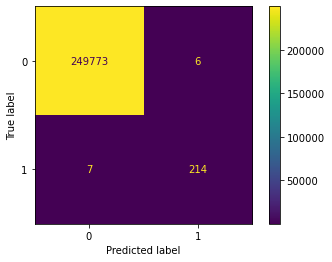

In [30]:
model_result(clf_tree,X_train1,Y_train1)
model_result(clf_tree,X_test1,Y_test1)

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_tree, X_test1, Y_test1) 

In [32]:
import xgboost as xgb
boost = xgb.XGBClassifier()
boost.fit(X_train1, Y_train1)

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[13:35:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
model_result(boost,X_train1,Y_train1)
model_result(boost,X_test1,Y_test1)

AUPRC : 1.0
F1 - score : 0.9935205183585313
Confusion_matrix : 
[[499767      0]
 [     3    230]]
accuracy_score
0.999994
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    499767
           1       1.00      0.99      0.99       233

    accuracy                           1.00    500000
   macro avg       1.00      0.99      1.00    500000
weighted avg       1.00      1.00      1.00    500000

AUPRC : 0.9731610925616462
F1 - score : 0.9839080459770114
Confusion_matrix : 
[[249779      0]
 [     7    214]]
accuracy_score
0.999972
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249779
           1       1.00      0.97      0.98       221

    accuracy                           1.00    250000
   macro avg       1.00      0.98      0.99    250000
weighted avg       1.00      1.00      1.00    250000



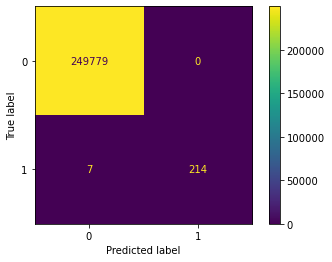

In [32]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(boost, X_test1, Y_test1) 

In [46]:
y_prob=boost.predict_proba(X_test1)
y_pred=boost.predict(X_test1)

matrice = confusion_matrix(Y_test1,y_pred)
print(matrice)


[[249779      0]
 [     7    214]]


In [ ]:
df_train.loc(y_pred!=df_train['isFraud']).head(7)

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix

# Standardisation des variables X 

In [35]:
data_type = pd.DataFrame(X_train1.dtypes.astype(str), columns=['type'])
print(data_type)
X_col = list(X_train1.columns)

#standardisation 
#var quanti

# Standardisation des variables pour les régressions logistiques
std = pp.StandardScaler()
std.fit(X_train1)
X_train2 = pd.DataFrame(data = std.transform(X_train1), columns = X_col)
X_test2 = pd.DataFrame(data = std.transform(X_test1), columns = X_col)

                   type
step              int64
amount          float64
oldbalanceOrg   float64
newbalanceOrig  float64
oldbalanceDest  float64
newbalanceDest  float64
CASH_OUT          int64
TRANSFER          int64
C                 int64
Erreur_orig     float64
Erreur_dest     float64


In [36]:
boost = xgb.XGBClassifier()
boost.fit(X_train2, Y_train1)
model_result(boost,X_train2,Y_train1)
model_result(boost,X_test2,Y_test1)

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:25:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC : 1.0
F1 - score : 0.9935205183585313
Confusion_matrix : 
[[499767      0]
 [     3    230]]
accuracy_score
0.999994
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    499767
           1       1.00      0.99      0.99       233

    accuracy                           1.00    500000
   macro avg       1.00      0.99      1.00    500000
weighted avg       1.00      1.00      1.00    500000

AUPRC : 0.9770033883933086
F1 - score : 0.9839080459770114
Confusion_matrix : 
[[249779      0]
 [     7    214]]
accuracy_score
0.999972
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

[14:40:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train F1-score : 0.9890300854382581
Valid F1-score : 0.9919470168932027


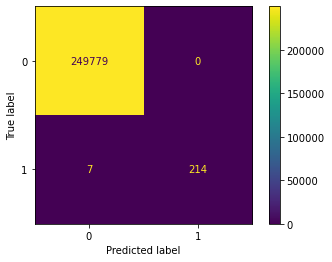

In [173]:
from sklearn.metrics import plot_confusion_matrix
boost.fit(X_train2, Y_train1)
F1score(Y_train1,X_train2,Y_test1,X_test2,boost)
plot_confusion_matrix(boost, X_test2, Y_test1) 

In [91]:
Y_train1 = Y_train1.values.ravel()
Y_test1 = Y_test1.values.ravel()

In [37]:


RF = RandomForestClassifier(max_depth=20, n_estimators=10)
RF.fit(X_train2, Y_train1)
model_result(RF,X_train2,Y_train1)
model_result(RF,X_test2,Y_test1)


<ipython-input-37-e34fb45c5a77>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train2, Y_train1)


AUPRC : 0.9999633175598841
F1 - score : 0.9935205183585313
Confusion_matrix : 
[[499767      0]
 [     3    230]]
accuracy_score
0.999994
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    499767
           1       1.00      0.99      0.99       233

    accuracy                           1.00    500000
   macro avg       1.00      0.99      1.00    500000
weighted avg       1.00      1.00      1.00    500000

AUPRC : 0.9733708590305807
F1 - score : 0.9839080459770114
Confusion_matrix : 
[[249779      0]
 [     7    214]]
accuracy_score
0.999972
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249779
           1       1.00      0.97      0.98       221

    accuracy                           1.00    250000
   macro avg       1.00      0.98      0.99    250000
weighted avg       1.00      1.00      1.00    250000



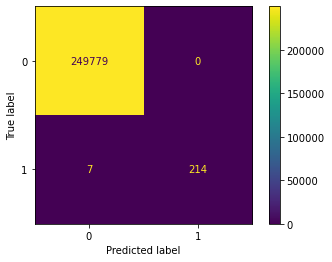

In [38]:
plot_confusion_matrix(RF, X_test2, Y_test1) 

In [39]:
#pd.crosstab(df_train['type'], df_train['isFraud'])
#l'idée est de garder des observations selon type et C 

df_train1 = df_train.loc[((df_train['type']=='CASH_OUT') |
             (df_train['type']=='TRANSFER')) &
            (df_train['dest']=='C')]

df_test1 = df_test.loc[((df_test['type']=='CASH_OUT') |
             (df_test['type']=='TRANSFER')) &
            (df_test['dest']=='C')]



In [40]:
#var_expli = ['step', 'amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
#            'old_compte_zero_dest','new_compte_zero_dest','OrigC_zero_dest','Orig_newbal_zero_destC',
#            'CASH_OUT','TRANSFER']
var_expli = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
            'CASH_OUT','TRANSFER','C','Erreur_orig','Erreur_dest']

target = ['isFraud']

X_train= df_train1[var_expli]
Y_train= df_train1[target]
X_test = df_test1[var_expli]
Y_test= df_test1[target]

In [41]:
boost = xgb.XGBClassifier()
boost.fit(X_train, Y_train)
model_result(boost,X_train,Y_train)
model_result(boost,X_test,Y_test)

/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:31:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC : 1.0
F1 - score : 0.9935205183585313
Confusion_matrix : 
[[222813      0]
 [     3    230]]
accuracy_score
0.9999865498596702
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    222813
           1       1.00      0.99      0.99       233

    accuracy                           1.00    223046
   macro avg       1.00      0.99      1.00    223046
weighted avg       1.00      1.00      1.00    223046

AUPRC : 0.9720180560509598
F1 - score : 0.9839080459770114
Confusion_matrix : 
[[108756      0]
 [     7    214]]
accuracy_score
0.9999357662626058
classification
              precision    recall  f1-score   support

           0       1.00  

In [183]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train2, Y_train1)
lgb_eval = lgb.Dataset(X_test2, Y_test1, reference=lgb_train)
# specify your configurations as a dict
#Specifying the parameter
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)


print('Saving model...')


print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test2, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(Y_test1, y_pred) ** 0.5)

Starting training...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 233, number of negative: 499767
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000466 -> initscore=-7.670859
[LightGBM] [Info] Start training from score -7.670859
[1]	valid_0's binary_logloss

In [184]:
#rounding the values
y_pred=y_pred.round(0)
#converting from float to integer
y_pred=y_pred.astype(int)

In [185]:
#roc_auc_score metric
f1_score(Y_test1, y_pred)

0.9815668202764977

In [90]:
print(y_pred)

[0 0 0 ... 0 0 0]


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   25.4s finished
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 16, 'num_leaves': 20, 'objective': 'binary', 'random_state': 501, 'subsample': 0.7}
0.999838
Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 20, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 233, number of negative: 499767
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Overall accuracy of Light GBM model: 0.999968


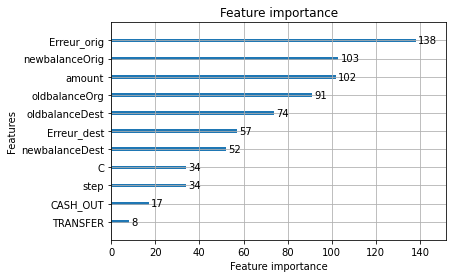

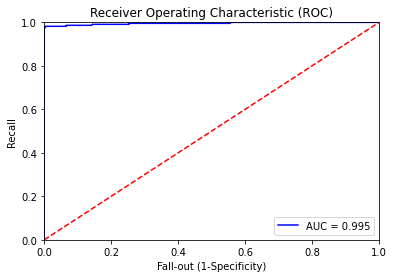

AUC score: 0.9953761387509998


<Figure size 432x288 with 0 Axes>

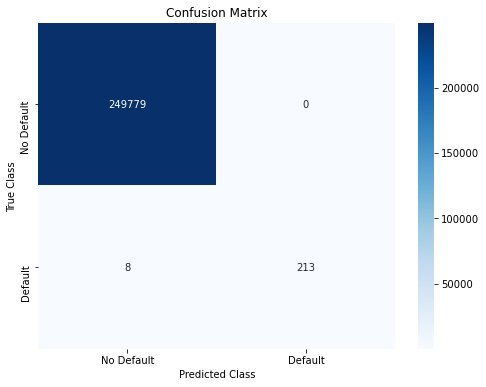

In [47]:
#Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
#Define 'y' labels
train_y = Y_train1
test_y = Y_test1

#Define 'x' sets
train_x = X_train1
test_x = X_test1

#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x, label=train_y)

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

# Create parameters to search
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

# Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# View the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

# Run the grid
grid.fit(train_x, train_y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 280,
                 #early_stopping_rounds= 40,
                 verbose_eval= 4
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(test_x)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(test_y,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_y, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [54]:
def model_result1(clf,x_test,y_test):
    y_pred=clf.predict(x_test)
    print('F1 - score :',(f1_score(y_test,y_pred.round(),average='binary')))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred.round()))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred.round()))
    print("classification")
    print(classification_report(y_test,y_pred.round()))
    
    
model_result1(lgbm,X_train,Y_train)
model_result1(lgbm,X_test,Y_test)

F1 - score : 0.9598214285714286
Confusion_matrix : 
[[222813      0]
 [    18    215]]
accuracy_score
0.9999192991580212
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    222813
           1       1.00      0.92      0.96       233

    accuracy                           1.00    223046
   macro avg       1.00      0.96      0.98    223046
weighted avg       1.00      1.00      1.00    223046

F1 - score : 0.9815668202764977
Confusion_matrix : 
[[108756      0]
 [     8    213]]
accuracy_score
0.9999265900144068
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    108756
           1       1.00      0.96      0.98       221

    accuracy                           1.00    108977
   macro avg       1.00      0.98      0.99    108977
weighted avg       1.00      1.00      1.00    108977



In [216]:
#CNN 
# Library CNN Tensorflow et keras
#Librairie tensorflow et keras
from keras.datasets import mnist
import tensorflow as tf
import keras as ks
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import AvgPool2D, BatchNormalization, Reshape
from keras.optimizers import Adadelta, RMSprop, Adam
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets, svm, metrics, model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from collections import defaultdict



def large_model():
    # create model
    model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
    
])
    METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

    model.compile(optimizer=keras.optimizers.Adam(1e-2), loss='binary_crossentropy', metrics=METRICS)
    return model


# Matrice de confusion en heatmap

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
 
   #Define 'y' labels
train_y = Y_train
test_y = Y_test

#Define 'x' sets
train_x = X_train
test_x = X_test 

def model_CNN(model):
    modeCNN = model
    history_cnn = modeCNN.fit(train_x, train_y, validation_data=(test_x,test_y ),epochs=10, batch_size=100, verbose = 1)
    acc = history_cnn.history['precision']
    y_pred = modeCNN.predict_classes(test_x)
    y_pred = to_categorical(y_pred)
    matrice_confusion = confusion_matrix(test_y , y_pred)
    print("Matrice de confusion : ",confusion_matrix(test_y, y_pred))
    print("Accuracy score sur Y_test : ",accuracy_score(test_y , y_pred)*100,"%")
    classe = [0,1,2,3,4,5,6,7,8,9]
    # plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(matrice_confusion,classe, title='Normalized confusion matrix')
    plt.show()
    return history_cnn


Epoch 1/10
2231/2231 [==============================] - 5s 2ms/step - loss: 1258.7178 - fn: 201.0000 - fp: 241.0000 - tn: 222572.0000 - tp: 32.0000 - precision: 0.1172 - recall: 0.1373 - val_loss: 222.8880 - val_fn: 221.0000 - val_fp: 5.0000 - val_tn: 108751.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
2231/2231 [==============================] - 5s 2ms/step - loss: 21.6778 - fn: 233.0000 - fp: 72.0000 - tn: 222741.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 51.3819 - val_fn: 221.0000 - val_fp: 0.0000e+00 - val_tn: 108756.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
2231/2231 [==============================] - 5s 2ms/step - loss: 127.0713 - fn: 233.0000 - fp: 47.0000 - tn: 222766.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 374.7405 - val_fn: 221.0000 - val_fp: 0.0000e+00 - val_tn: 108756.0000 - val_tp: 0.0000e+00 - val_precision

<Figure size 432x288 with 0 Axes>

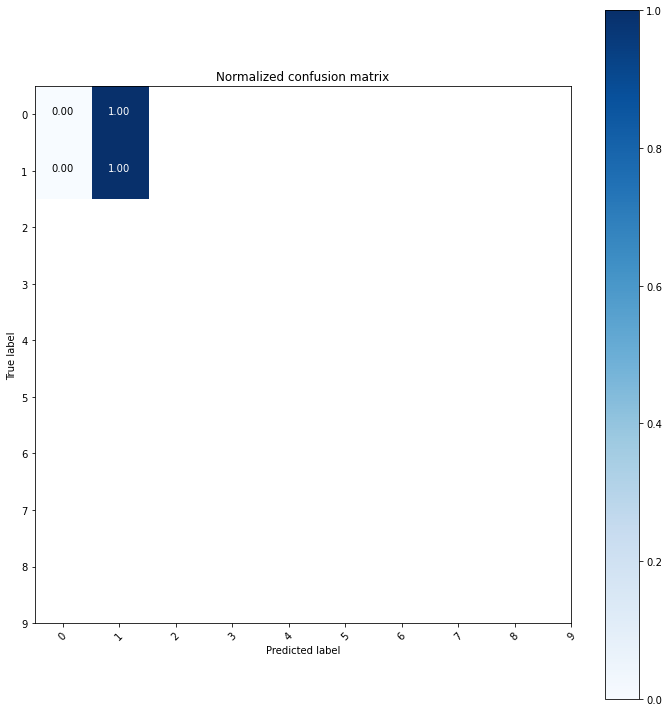

In [217]:
hist_medium = model_CNN(large_model())

In [36]:
#modèle mois 1 
mois1_train = X_train1.loc[(df_train['step']==7) | (df_train['step']==8)|(df_train['step']==9)|
            (df_train['step']==10)|(df_train['step']==11)|(df_train['step']==12)]
mois1_Ytrain=Y_train1.loc[(df_train['step']==7) | (df_train['step']==8)|(df_train['step']==9)|
            (df_train['step']==10)|(df_train['step']==11)|(df_train['step']==12)]

mois1_test = X_train1.loc[df_train['step']==16]
mois1_Ytest=Y_train1.loc[df_train['step']==16]

mois1_Xtrain= mois1_train[var_expli]
mois1_Xtest = mois1_test[var_expli]

In [38]:
import xgboost as xgb
boost = xgb.XGBClassifier()
boost.fit(mois1_Xtrain, mois1_Ytrain)
model_result(boost,mois1_Xtrain, mois1_Ytrain)
model_result(boost,mois1_Xtest,mois1_Ytest)



/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/teriitehau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[11:11:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC : 0.9999999999999999
F1 - score : 0.9932885906040269
Confusion_matrix : 
[[174872      0]
 [     1     74]]
accuracy_score
0.9999942839831492
classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    174872
           1       1.00      0.99      0.99        75

    accuracy                           1.00    174947
   macro avg       1.00      0.99      1.00    174947
weighted avg       1.00      1.00      1.00    174947

AUPRC : 1.0
F1 - score : 0.9523809523809523
Confusion_matrix : 
[[42460     1]
 [    0    10]]
accuracy_score
0.9999764545219091
classification
              precision    recall  f1-score   support

           0       1.00      

In [39]:
mois1_Xtest= X_test1.loc[df_test['step']==21]
mois1_Ytest=Y_test1.loc[df_test['step']==21]

#model_result(boost,mois1_Xtest,mois1_Ytest)

In [40]:
y_pred = boost.predict(mois1_Xtest)

test = confusion_matrix(mois1_Ytest,y_pred.round())

In [41]:
print(test)

[[19147     0]
 [    1     4]]


In [45]:
#realiser une boucle sur tout les step

perf = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect'])

for i in range(0,20):
    mois1_Xtest = X_train1.loc[df_train['step']==i+1]
    mois1_Ytest=Y_train1.loc[df_train['step']==i+1]
    y_pred = boost.predict(mois1_Xtest)
    test1 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+1]=test1[1,0]
    perf.loc['true_no_fraud',i+1] =test1[0,0]
    perf.loc['false_fraud',i+1]=test1[0,1]
    perf.loc['true_fraud',i+1] =test1[1,1]
    perf.loc['false_expect',i+1] =test1[0,1]+test1[1,0]
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect
1,2.0,2692.0,0.0,14.0,2.0
2,0.0,1006.0,0.0,8.0,0.0
3,0.0,548.0,0.0,4.0,0.0
4,0.0,555.0,0.0,10.0,0.0
5,0.0,659.0,0.0,6.0,0.0
6,0.0,1638.0,0.0,22.0,0.0
7,0.0,6825.0,0.0,12.0,0.0
8,0.0,21085.0,0.0,12.0,0.0
9,0.0,37609.0,0.0,19.0,0.0
10,0.0,35980.0,0.0,11.0,0.0


In [43]:


perf = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect'])

for i in range(0,19):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test1 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+1]=test1[1,0]
    perf.loc['true_no_fraud',i+1] =test1[0,0]
    perf.loc['false_fraud',i+1]=test1[0,1]
    perf.loc['true_fraud',i+1] =test1[1,1]
    perf.loc['false_expect',i+1] =test1[0,1]+test1[1,0]
perf.T

IndexError: index 1 is out of bounds for axis 0 with size 1

In [155]:

perf2 = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect'])
perf2

""
false_no_fraud
true_no_fraud
false_fraud
true_fraud
false_expect


In [94]:

perf = pd.DataFrame(index=['false_no_fraud', 'true_no_fraud', 'false_fraud','true_fraud'
                          ,'false_expect','F1_SCORE'])

for i in range(0,7):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test2 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+21]=test2[1,0]
    perf.loc['true_no_fraud',i+21] =test2[0,0]
    perf.loc['false_fraud',i+21]=test2[0,1]
    perf.loc['true_fraud',i+21] =test2[1,1]
    perf.loc['false_expect',i+21] =test2[0,1]+test2[1,0]
    perf.loc['F1_SCORE',i+21] =f1_score(mois1_Ytest,y_pred.round(),average='binary')
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect,F1_SCORE
21,1.0,19147.0,0.0,4.0,1.0,0.888889
22,1.0,12612.0,0.0,22.0,1.0,0.977778
23,0.0,6142.0,0.0,2.0,0.0,1.000000
24,0.0,3210.0,0.0,6.0,0.0,1.000000
25,0.0,1580.0,0.0,18.0,0.0,1.000000
26,0.0,428.0,0.0,12.0,0.0,1.000000
27,0.0,33.0,0.0,8.0,0.0,1.000000


In [95]:
for i in range(7,12):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test2 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+21]=0
    perf.loc['true_no_fraud',i+21] =0
    perf.loc['false_fraud',i+21]=0
    perf.loc['true_fraud',i+21] =test2
    perf.loc['false_expect',i+21] =0
    perf.loc['F1_SCORE',i+21] =f1_score(mois1_Ytest,y_pred.round(),average='binary')
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect,F1_SCORE
21,1.0,19147.0,0.0,4.0,1.0,0.888889
22,1.0,12612.0,0.0,22.0,1.0,0.977778
23,0.0,6142.0,0.0,2.0,0.0,1.000000
24,0.0,3210.0,0.0,6.0,0.0,1.000000
25,0.0,1580.0,0.0,18.0,0.0,1.000000
26,0.0,428.0,0.0,12.0,0.0,1.000000
27,0.0,33.0,0.0,8.0,0.0,1.000000
28,0.0,0.0,0.0,4.0,0.0,1.000000
29,0.0,0.0,0.0,4.0,0.0,1.000000
30,0.0,0.0,0.0,8.0,0.0,1.000000


In [96]:
for i in range(12,19):
    mois1_Xtest= X_test1.loc[df_test['step']==i+21]
    mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
    y_pred = boost.predict(mois1_Xtest)
    test2 = confusion_matrix(mois1_Ytest,y_pred.round())
    perf.loc['false_no_fraud',i+21]=test2[1,0]
    perf.loc['true_no_fraud',i+21] =test2[0,0]
    perf.loc['false_fraud',i+21]=test2[0,1]
    perf.loc['true_fraud',i+21] =test2[1,1]
    perf.loc['false_expect',i+21] =test2[0,1]+test2[1,0]
    perf.loc['F1_SCORE',i+21] =f1_score(mois1_Ytest,y_pred.round(),average='binary')
perf.T

,false_no_fraud,true_no_fraud,false_fraud,true_fraud,false_expect,F1_SCORE
21,1.0,19147.0,0.0,4.0,1.0,0.888889
22,1.0,12612.0,0.0,22.0,1.0,0.977778
23,0.0,6142.0,0.0,2.0,0.0,1.000000
24,0.0,3210.0,0.0,6.0,0.0,1.000000
25,0.0,1580.0,0.0,18.0,0.0,1.000000
26,0.0,428.0,0.0,12.0,0.0,1.000000
27,0.0,33.0,0.0,8.0,0.0,1.000000
28,0.0,0.0,0.0,4.0,0.0,1.000000
29,0.0,0.0,0.0,4.0,0.0,1.000000
30,0.0,0.0,0.0,8.0,0.0,1.000000


In [123]:
mois1_Xtest= X_test1.loc[df_test['step']==i+21]
mois1_Ytest=Y_test1.loc[df_test['step']==i+21]
y_pred = pd.DataFrame(boost.predict_proba(mois1_Xtest), columns=['0','1'])
y_pred
y_pred.sort_index(axis = 0, ascending = True) 

,0,1
0,0.999998,1.614048e-06
1,1.000000,1.943949e-07
2,0.999995,5.073387e-06
3,0.999997,2.617115e-06
4,0.999966,3.441875e-05
...,...,...
17825,0.999884,1.163422e-04
17826,0.999994,5.880766e-06
17827,0.999998,1.629293e-06
17828,0.999998,1.943546e-06


In [101]:
y_pred = boost.predict(mois1_Xtest)
test2 = confusion_matrix(mois1_Ytest,y_pred.round())
print(test2)

[[17820     0]
 [    0    10]]


In [128]:
print(y_pred.sort_values(by=['1'], ascending = False).head(15))

              0         1
12348  0.000343  0.999657
1349   0.001666  0.998334
2190   0.004359  0.995641
2191   0.004456  0.995544
4484   0.007962  0.992038
4485   0.008619  0.991381
17117  0.009217  0.990783
1350   0.011716  0.988284
17118  0.043972  0.956028
12349  0.062261  0.937739
6986   0.972497  0.027503
15766  0.975428  0.024572
6388   0.980056  0.019944
13829  0.986351  0.013649
12404  0.993308  0.006692
